# Default estimator and WoE binning 

### Adding project directory to system path

In [1]:
import pandas as pd
import os
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Importing modules

In [2]:
from script.default_estimator_and_WoE_binning import Estimator

### Loading the data

In [3]:
data=pd.read_csv("data/data.csv")

### Instantiate class

In [4]:
estimator=Estimator()

## Construct the RFMS Default Estimator
To classify users into high-risk (bad) or low-risk (good) groups using the RFMS formalism, we need to define the key components of the RFMS model based on Recency, Frequency, Monetary, and Stability (RFMS) and use these features to establish a score that can serve as a proxy for estimating the default risk.

**Feature Construction:**
* **Recency (R)**: The number of days since the last transaction.

* **Frequency (F)**: The total number of transactions made by the customer.

* **Monetary (M)**: The total monetary value of all transactions.

* **Stability (S)**: The standard deviation of the customer’s transaction amounts (to measure consistency).

In [5]:
rfms_scores=estimator.calculate_rfms(data)
rfms_scores.head()

,Recency,Frequency,Monetary,Stability
CustomerId,,,,
CustomerId_1,83,1,-10000.0,0.000000
CustomerId_10,83,1,-10000.0,0.000000
CustomerId_1001,89,5,20000.0,6558.963333
CustomerId_1002,25,11,4225.0,560.498966
CustomerId_1003,11,6,20000.0,6030.478146


## Visualizing RFMS Features
Now that we have the RFMS scores for each customer, we can visualize these features in a multi-dimensional space to establish boundaries between high RFMS (good) and low RFMS (bad) customers.

We visualize**Recency**, **Frequency**, and **Monetary** in a 3D space, with **Stability** as a color scale or size of the points.

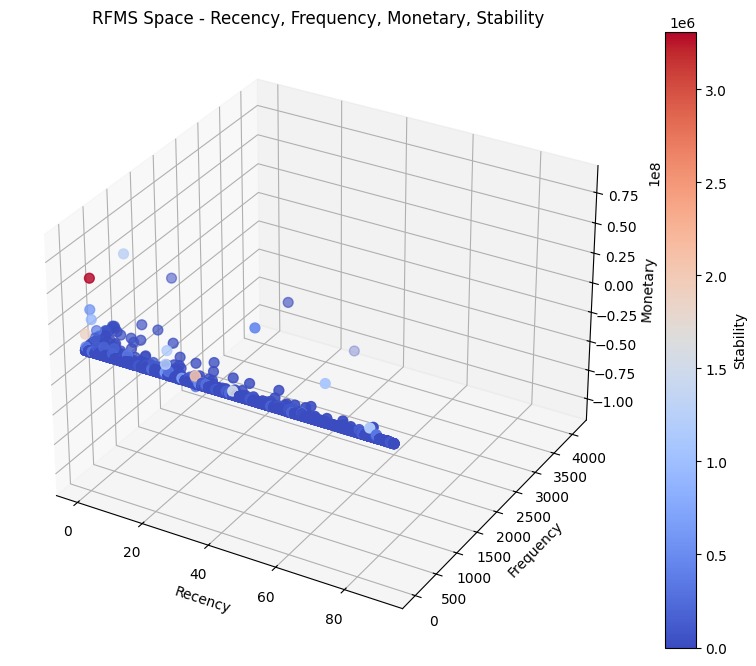

In [6]:
estimator.visualize_rfms(rfms_scores)

## Establishing the Boundary for Good/Bad Classification
a common approach,to define boundaries between high-risk (low RFMS) and low-risk (high RFMS) groups,is to divide customers based on quartiles of their RFMS scores. Assign 1 for High risk and 0 for low risk.

*RiskScore=Recency+Frequency+Monetary+Stability*

Based on whether a specific user’s RiskScore  is below or above the median is used to label high risk(1) and low risk(0) 


In [7]:
rfms_labeled = estimator.assign_good_bad_labels(rfms_scores)
rfms_labeled.head()

,Recency,Frequency,Monetary,Stability,RiskScore,RiskLabel
CustomerId,,,,,,
CustomerId_1,83,1,-10000.0,0.000000,13945.0,1
CustomerId_10,83,1,-10000.0,0.000000,13945.0,1
CustomerId_1001,89,5,20000.0,6558.963333,8993.5,1
CustomerId_1002,25,11,4225.0,560.498966,8936.0,1
CustomerId_1003,11,6,20000.0,6030.478146,6579.0,0


Binning,Weight of Evidence (WoE) and Information Value(IV)

### Merge the prepared data set on the feature engineering section and the customer level data that is used to calculate RFMS score

In [8]:
merged_data=estimator.merge_dataframes(data,rfms_labeled)

In [9]:
merged_data.head()

,ProviderId,ProductId,ProductCategory,ChannelId,Amount,PricingStrategy,FraudResult,Recency,Frequency,Monetary,Stability,RiskScore,RiskLabel
0,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,strat2,0,0,119,109921.75,3042.294251,2931.0,0
1,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,strat2,0,0,119,109921.75,3042.294251,2931.0,0
2,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,strat2,0,81,2,1000.00,0.000000,12976.0,1
3,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,strat2,0,5,38,228727.20,17169.241610,2167.0,0
4,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,strat2,0,5,38,228727.20,17169.241610,2167.0,0


### Check the target balance (RiskLabel)

In [10]:
merged_data.stb.freq(['RiskLabel'], style = True)

,RiskLabel,count,percent,cumulative_count,cumulative_percent
0,0,"87,997",91.99%,"87,997",91.99%
1,1,"7,665",8.01%,"95,662",100.00%


## WOE Transformation
**Key Features**
1. **Binning**:

Used in statistical analysis and machine learning to convert continuous variables into discrete categories or bins.

2. **WoE (Weight of Evidence) Transformation**:

Converts binned variables into Weight of Evidence, which is a common transformation used in credit scoring to quantify the predictive power of each category.


**Binning Parameters Explanation**
The Binning class is utilized to segment numeric variables into bins based on specific criteria:

**n_threshold=50:** This parameter sets the minimum number of unique values required in a variable to consider it for binning.
**y_threshold=10:** This specifies the minimum count of observations that must be present in each bin to ensure statistical significance.
**p_threshold=0.35:** This threshold determines the acceptable proportion of good versus bad loans within the bins, aiding in the identification of meaningful segments.

In [11]:
# Perform a 70 / 30 split of data
train, test=estimator.split_data(merged_data)

# calculate woe
y_var,breaks=estimator.woe_num(train,'RiskLabel')
breaks

{'Amount': [-25000.0, -15000.0, -5000.0, -12.1, 770000.0, 9880000.0],
 'FraudResult': [1.0],
 'Recency': [0.0,
  1.0,
  4.0,
  6.0,
  7.0,
  11.0,
  28.0,
  33.0,
  34.0,
  36.0,
  41.0,
  45.0,
  54.0,
  65.0,
  70.0,
  82.0,
  86.0,
  90.0],
 'Frequency': [4091.0],
 'Monetary': [83451240.0],
 'Stability': [3309916.123615392],
 'RiskScore': [14063.0]}

### Interpretation of Binning Results

The following bins have been established for the numeric variables in the dataset, indicating the cut points for each feature:

- **Amount**: Bins $-25000.0, $-15000.0, $-5000.0, $-12.1, $770000.0 and $9880000.0 amount per transaction.
- **FraudResult**: Single bin at 1(fraud).
- **Recency**: Bins  at 0.0,1.0,4.0,6.0,7.0,11.0,28.0,33.0,34.0,36.0,41.0,45.0,54.0,65.0,70.0,82.0,86.0 at 90.0 days.
- **Frequency**: Single bin at 4091.0 number of transaction .
- **Monetary**: Single bin at $83451240.0 total amount per customer .
- **Stability**: Single bin at $3309916.123615392 amount standard deviation.
- **RiskScore**: Single bin at 14063.0 risk score.

These bins will be used to calculate the Weight of Evidence (WoE) for each variable, aiding in predictive modeling and risk assessment.


### Binning for catagorical features

In [12]:
breaks_list=estimator.bin_catagorical_features(train)

[INFO] creating woe binning ...


In [13]:
# import dictionary
# from cat_breaks_20241008_173147 import breaks_list
# breaks_list

# merge
breaks.update(breaks_list)
print(breaks)

{'Amount': [-25000.0, -15000.0, -5000.0, -12.1, 770000.0, 9880000.0], 'FraudResult': [1.0], 'Recency': [0.0, 1.0, 4.0, 6.0, 7.0, 11.0, 28.0, 33.0, 34.0, 36.0, 41.0, 45.0, 54.0, 65.0, 70.0, 82.0, 86.0, 90.0], 'Frequency': [4091.0], 'Monetary': [83451240.0], 'Stability': [3309916.123615392], 'RiskScore': [14063.0], 'ProviderId': ['ProviderId_2%,%ProviderId_6', 'ProviderId_4', 'ProviderId_5', 'ProviderId_3%,%ProviderId_1'], 'ProductId': ['ProductId_22%,%ProductId_23%,%ProductId_7%,%ProductId_14%,%ProductId_8%,%ProductId_19%,%ProductId_13%,%ProductId_21%,%ProductId_3%,%ProductId_1', 'ProductId_6%,%ProductId_20%,%ProductId_10%,%ProductId_2', 'ProductId_4%,%ProductId_11%,%ProductId_27%,%ProductId_15%,%ProductId_5%,%ProductId_24%,%ProductId_16%,%ProductId_9%,%ProductId_12'], 'ProductCategory': ['tv%,%utility_bill%,%ticket%,%airtime', 'financial_services%,%data_bundles%,%transport%,%movies%,%other'], 'ChannelId': ['ChannelId_2', 'ChannelId_3%,%ChannelId_5%,%ChannelId_1'], 'PricingStrategy': ['

## Plotting WoE and IV for each feature

[INFO] creating woe binning ...


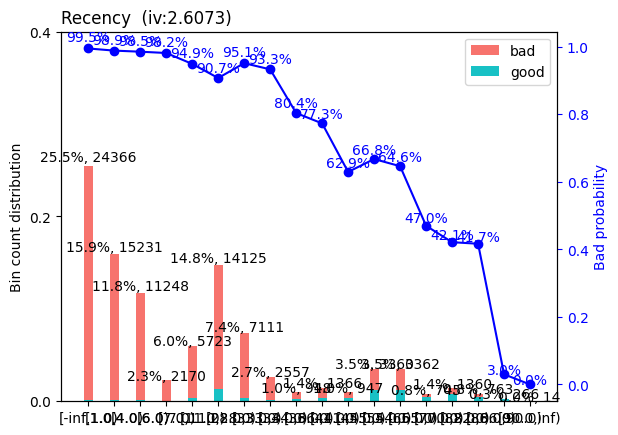

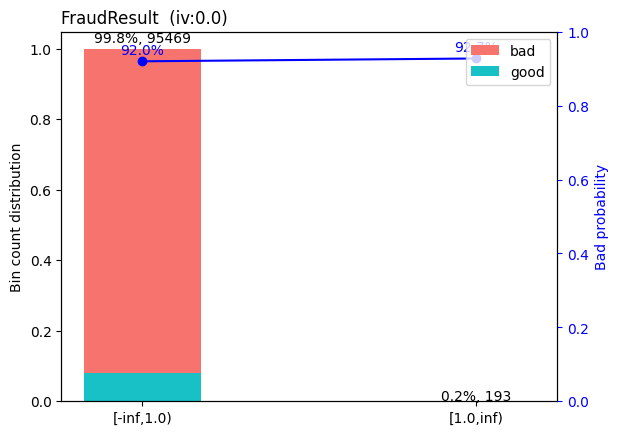

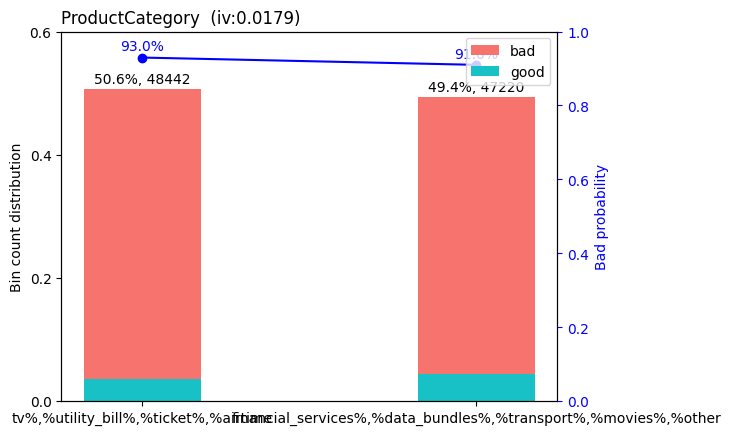

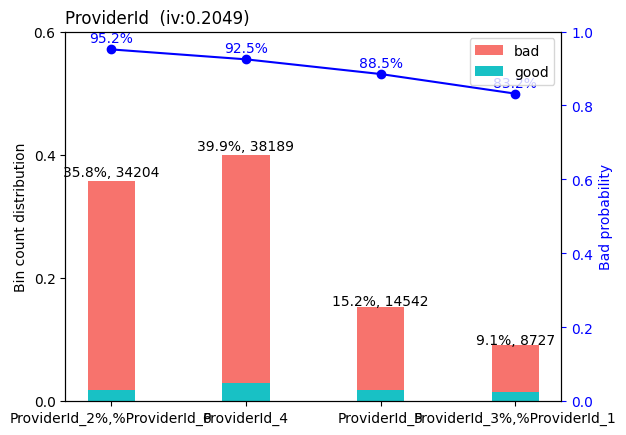

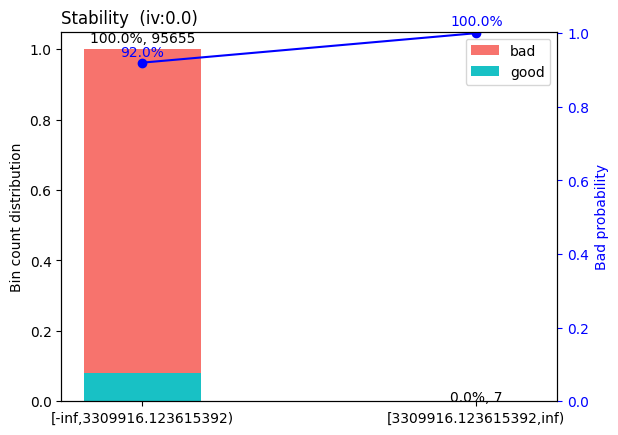

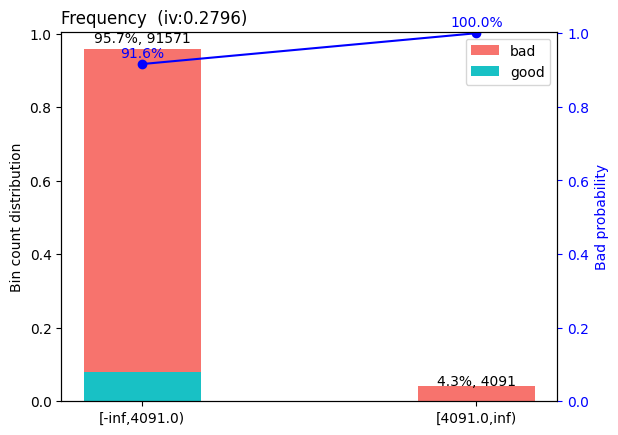

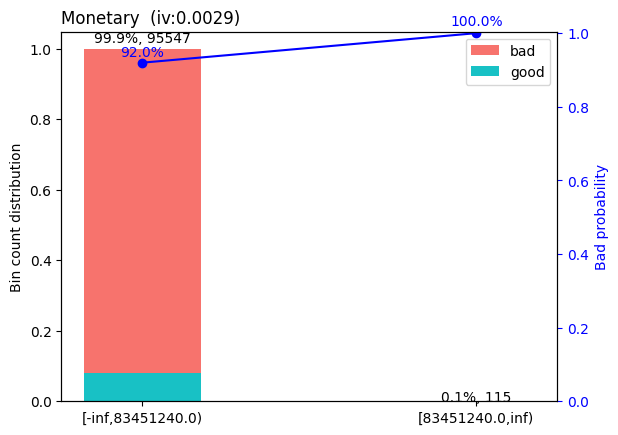

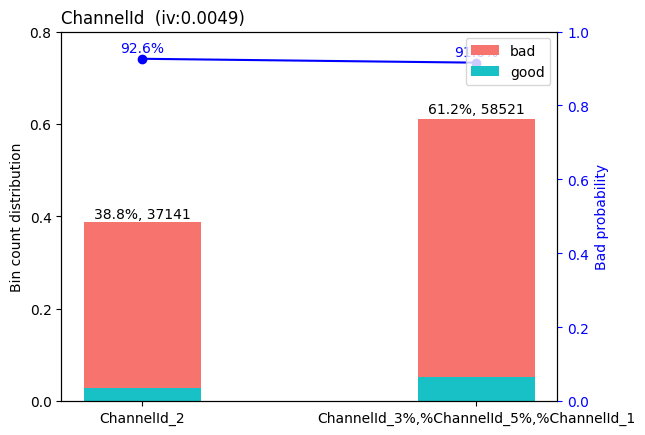

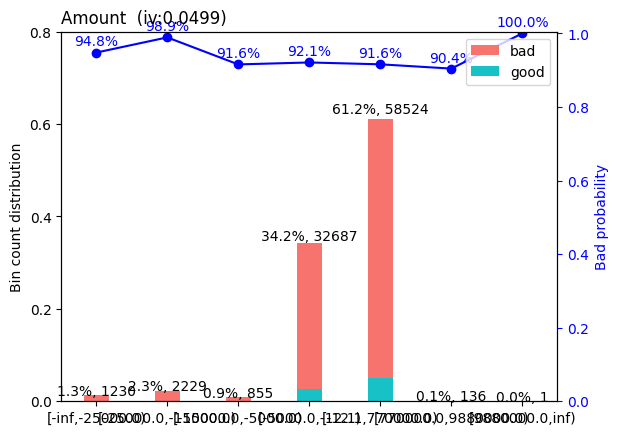

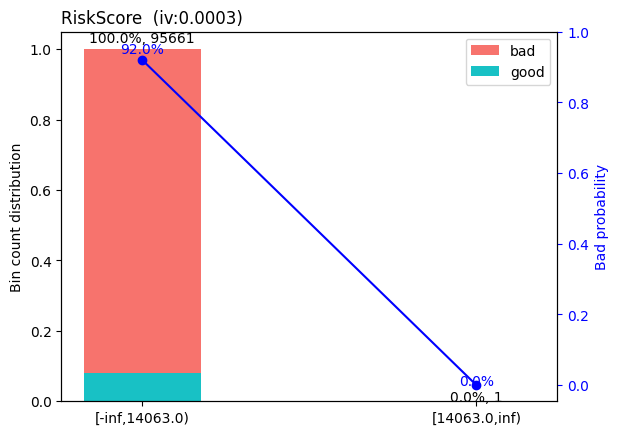

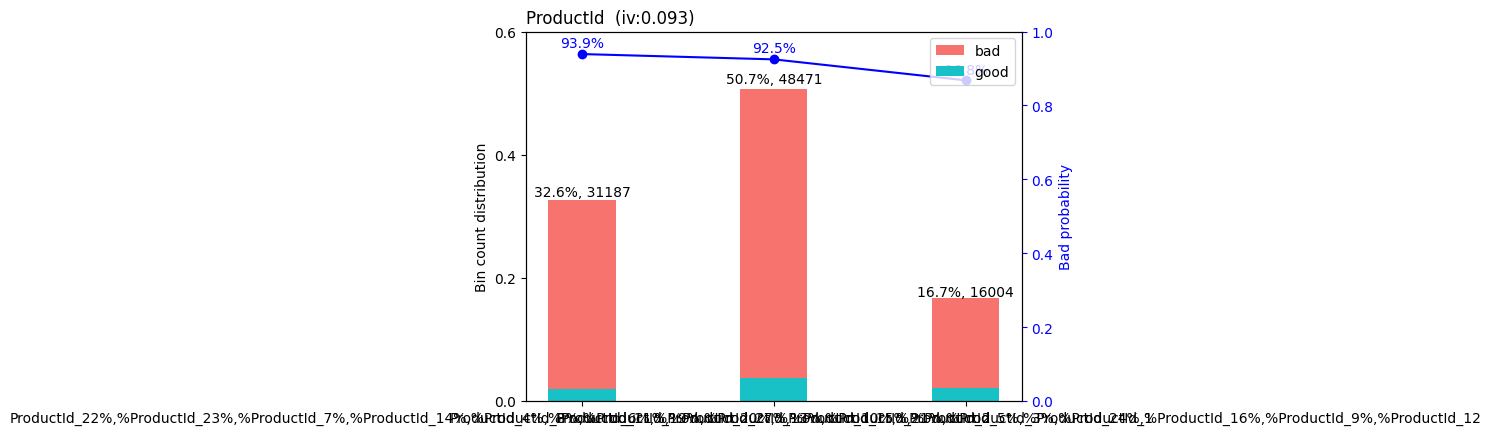

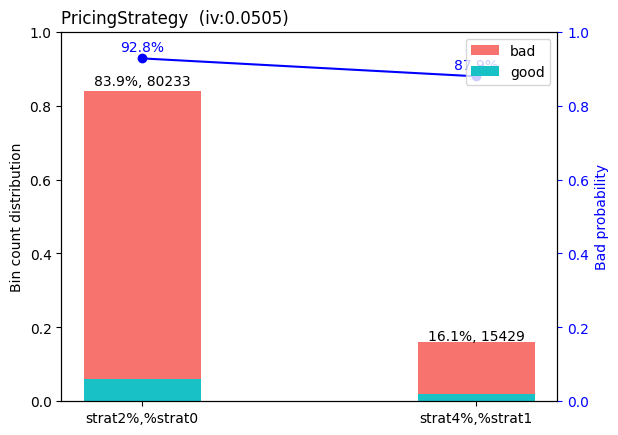

In [14]:
bins_adj=estimator.plot_woe_iv(merged_data,breaks)

### Plot interpretation

**Amount**

The WoE binning plot provides a visual representation of the relationship between the Amount variable and the probability of default (bad probability).

**Key Insight**

* Monotonic Relationship: The plot shows a clear monotonic relationship between Amount and bad probability. As the Amount increases, the bad probability also increases, indicating a positive association between the two variables.

* Informative Bins: The binning process has created informative bins that capture the different levels of risk associated with different ranges of Amount.

**ProviderId**

The WoE binning plot provides a visual representation of the relationship between the ProviderId variable and the probability of default (bad probability).

**Key Observations:**

* Monotonic Relationship: There appears to be a general monotonic relationship between ProviderId and bad probability. However, the relationship is not as clear-cut as in the previous plot for Amount.

* Informative Bins: The binning process has created informative bins that capture different levels of risk associated with different ProviderId categories.


### Converting train and test into woe values

In [15]:
train_final,test_final=estimator.converting_into_woe_values(train,test,bins_adj)
train_final.head(10)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


,Amount,FraudResult,Recency,Frequency,Monetary,Stability,RiskScore,vd,Recency_woe,FraudResult_woe,ProductCategory_woe,ProviderId_woe,Stability_woe,Frequency_woe,Monetary_woe,ChannelId_woe,Amount_woe,RiskScore_woe,ProductId_woe,PricingStrategy_woe
0,1000.0,0,0,119,109921.75,3042.294251,2931.0,0,2.843050,-0.000208,0.140023,0.538307,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,0.067311,0.111217
1,-20.0,0,0,119,109921.75,3042.294251,2931.0,0,2.843050,-0.000208,-0.128347,0.068718,0.000038,-0.047488,-0.00119,0.090278,0.016868,0.00012,0.067311,0.111217
2,500.0,0,81,2,1000.00,0.000000,12976.0,1,-2.757991,-0.000208,0.140023,0.538307,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,0.294091,0.111217
5,2000.0,0,90,1,2000.00,0.000000,13451.0,1,-5.185066,-0.000208,0.140023,0.538307,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,0.294091,0.111217
6,10000.0,0,5,29,93400.00,5493.966126,3952.5,0,1.772743,-0.000208,0.140023,-0.399760,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,0.294091,-0.455870
7,-500.0,0,5,29,93400.00,5493.966126,3952.5,0,1.772743,-0.000208,-0.128347,0.068718,0.000038,-0.047488,-0.00119,0.090278,0.016868,0.00012,0.067311,0.111217
9,600.0,0,89,7,13788.00,1911.444629,9957.5,1,-5.914166,-0.000208,-0.128347,-0.840658,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,-0.558051,0.111217
10,890.0,0,61,12,10700.00,691.777465,9539.0,1,-1.837652,-0.000208,0.140023,0.538307,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,0.294091,0.111217
12,600.0,0,89,7,13788.00,1911.444629,9957.5,1,-5.914166,-0.000208,-0.128347,-0.840658,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,-0.558051,0.111217
13,4000.0,0,89,7,13788.00,1911.444629,9957.5,1,-5.914166,-0.000208,-0.128347,-0.840658,0.000038,-0.047488,-0.00119,-0.053931,-0.050651,0.00012,-0.558051,0.111217


### Calculates information value (IV)

In [16]:
info_values_df=estimator.calculate_information_value(train_final)
info_values_df

,variable,info_value
2,Stability,6.144267
11,Monetary,5.914724
8,RiskScore,5.509965
3,Frequency,5.448058
0,Recency,3.128757
4,Recency_woe,2.543162
7,Amount,0.715453
17,Frequency_woe,0.261370
1,ProviderId_woe,0.210522
12,ProductId_woe,0.087230


### Explanation of Results

The interpretation of IV values is generally categorized as follows:
* IV < 0.02: Not useful for prediction
* 0.02 ≤ IV < 0.1: Weak predictive power
* 0.1 ≤ IV < 0.3: Medium predictive power
* 0.3 ≤ IV < 0.5: Strong predictive power
* IV ≥ 0.5: Very strong predictive power

These thresholds provide guidance on whether to retain or discard a feature based on its predictive capability.

1. **Stability(IV = 6.144267)**,**Monetary(IV = 5.914724)**,**RiskScore(IV = 5.509965)**,**Recency(IV = 3.128757)**,and **Recency_woe(IV = 2.543162)**: This variables has the highest IV, indicating they are a strong predictor of the target variable (`vd`). An IV above 1.0 typically suggests that the feature has excellent predictive power.

2. **Frequency_woe	(IV=0.261370)** and **ProviderId_woe(IV=0.210522)**: An IV above 0.1 and less than 0.3 typically suggests that the feature has Medium predictive power.

3. **ProductId_woe (IV = 0.087230)** , **Amount_woe (IV = 0.057319)** and **PricingStrategy_woe (IV = 0.056256)**: n IV above 0.02 and less than 0.1 typically suggests that the feature has Weak predictive power.

4. **The rest of variables**: Not useful for prediction


## Filter variables
The filter function implemented is based on the threshold removes features from a DataFrame that have an Information Value (IV) below a specified threshold=.02.

In [17]:
train_final=estimator.filter_columns_by_info_value(train_final,info_values_df, threshold=0.02)
test_final=estimator.filter_columns_by_info_value(test_final,info_values_df, threshold=0.02)
train_final

,Stability,Monetary,RiskScore,Frequency,Recency,Recency_woe,Amount,Frequency_woe,ProviderId_woe,ProductId_woe,Amount_woe,PricingStrategy_woe,vd
0,3042.294251,109921.75,2931.0,119,0,2.843050,1000.0,-0.047488,0.538307,0.067311,-0.050651,0.111217,0
1,3042.294251,109921.75,2931.0,119,0,2.843050,-20.0,-0.047488,0.068718,0.067311,0.016868,0.111217,0
2,0.000000,1000.00,12976.0,2,81,-2.757991,500.0,-0.047488,0.538307,0.294091,-0.050651,0.111217,1
5,0.000000,2000.00,13451.0,1,90,-5.185066,2000.0,-0.047488,0.538307,0.294091,-0.050651,0.111217,1
6,5493.966126,93400.00,3952.5,29,5,1.772743,10000.0,-0.047488,-0.399760,0.294091,-0.050651,-0.455870,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95655,6413.666676,120795.00,2502.5,44,0,2.843050,-50.0,-0.047488,0.068718,0.067311,0.016868,0.111217,0
95656,22554.029939,2438140.00,444.0,573,0,2.843050,50000.0,-0.047488,0.538307,0.067311,-0.050651,0.111217,0
95658,2274.756582,58499.60,3876.5,43,0,2.843050,1000.0,-0.047488,0.538307,0.067311,-0.050651,0.111217,0
95659,2274.756582,58499.60,3876.5,43,0,2.843050,-20.0,-0.047488,0.068718,0.067311,0.016868,0.111217,0


## Save train and test data

In [18]:
train_final.to_csv("data/train_data.csv",index=False)
test_final.to_csv("data/test_data.csv",index=False)